In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

02_04_25


In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [3]:
files_p112 = glob.glob('../data/P112_data/*.fits')
files_p113 = glob.glob('../data/P113_data/*.fits')


In [4]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [5]:
def get_dir(files):
    obj_dir = {}

    counts = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            snr     = header['SNR']
            counts.append(obj)

            grade   = header['OB_GRADE'].replace(" ", "")  
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err

            if obj in obj_dir.keys():
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
                obj_dir[obj]['snr'].append(snr)

            else:
                obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade], 'snr': [snr]}
          
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}

    return obj_dir

obj_dir_p112 = get_dir(files_p112)
obj_dir_p113 = get_dir(files_p113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [6]:
def combine_table(obj_dir):
    new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

    for k, v in obj_dir.items():
        if len(v['rv']) < 3: 
            continue
        result_table = Simbad.query_objectids(v['name'][0])
        result_table = np.array(result_table).astype('str')

        for i in result_table:
            if 'GALAH' in i: 
                galah_name = i.split(' ')[-1]

        new_df['RG_id'].append(k)
        new_df['galah_id'].append(int(galah_name))
        new_df['obj_name'].append(v['name'][0])

    new_df = pd.DataFrame(new_df)

    cols = ['sobject_id', 'vbroad', 'fe_h', 'e_fe_h' ,'Li_fe', 'e_Li_fe','ruwe_dr2','e_vbroad', 'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe']
    new_df = pd.merge(new_df, galah[cols], left_on='galah_id', right_on='sobject_id')
    new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05
    new_df['e_Li_val'] = np.sqrt(new_df.e_fe_h**2.+new_df.e_Li_fe**2.)

    cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'e_Li_val','vbroad','e_vbroad', 'fe_h','ruwe_dr2', 'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe']
    new_df = new_df[cols]
    new_df.sort_values(by=['RG_id'],inplace=True)
    
    new_df = new_df.round(2)
    return new_df

df_p112 = combine_table(obj_dir_p112)
df_p113 = combine_table(obj_dir_p113)


In [7]:
p112_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p112,left_on='sobject_id', right_on='galah_id', how='right')
p113_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p113,left_on='sobject_id', right_on='galah_id', how='right')


5

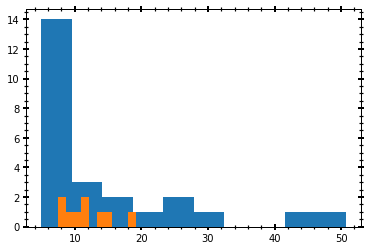

In [8]:
np.min(p113_galah.vbroad), np.max(p113_galah.vbroad)

plt.hist(p113_galah.vbroad)
plt.hist(p112_galah.vbroad)
p113_galah[p113_galah.vbroad <= 10].logg.count()
p113_galah[(p113_galah.vbroad > 10) & (p113_galah.vbroad < 20)].logg.count()
p113_galah[(p113_galah.vbroad >= 20)].logg.count()

In [9]:
p112_galah

,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,e_Li_val,vbroad,e_vbroad,fe_h,ruwe_dr2,Ba_fe,e_Ba_fe,La_fe,e_La_fe,Zr_fe,e_Zr_fe,Y_fe,e_Y_fe
0,150107004201104,1.792561,4190.288574,1,150107004201104,UCAC4 297-057956,3.41,0.07,11.29,2.10,-0.28,0.89,0.32,0.05,0.11,0.05,-0.10,0.05,0.40,0.08
1,151230003202196,1.955321,4321.995117,2,151230003202196,UCAC4 159-007674,2.10,0.12,11.37,2.20,-0.28,0.96,0.24,0.10,0.13,0.08,0.03,0.10,0.10,0.18
2,161013005401317,2.175321,4737.904297,4,161013005401317,TYC 763-2824-1,2.68,0.09,8.79,2.15,-0.47,0.93,0.47,0.06,0.13,0.06,-0.01,0.11,-0.05,0.09
3,161104004801189,1.390041,4299.760254,5,161104004801189,UCAC4 374-013344,2.96,0.11,7.49,2.19,-0.64,0.99,0.26,0.09,0.06,0.08,-0.01,0.15,0.05,0.13
4,150829004301285,2.119280,4928.102051,6,150829004301285,UCAC4 250-188426,1.79,0.14,7.95,2.29,-0.42,1.03,0.07,0.13,0.03,0.22,NaN,NaN,-0.03,0.19
5,160129003601260,2.817549,5152.436035,7,160129003601260,UCAC4 314-010619,2.60,0.13,10.03,2.25,-0.21,1.00,0.63,0.11,0.23,0.13,NaN,NaN,0.23,0.16
6,190212001601338,3.132823,4899.735840,13,190212001601338,2MASS J05354326-0034367,3.34,0.08,19.17,2.16,-0.00,0.93,0.14,0.06,0.44,0.10,NaN,NaN,0.08,0.09
7,140311007101261,2.368252,4635.878906,14,140311007101261,UCAC4 220-051792,3.24,0.11,15.26,2.20,0.00,1.02,0.52,0.09,0.29,0.17,NaN,NaN,-0.02,0.15
8,170514002101318,2.683253,5045.632324,23,170514002101318,CD-69 769,1.86,0.12,13.34,2.23,0.06,1.04,0.40,0.09,NaN,NaN,0.40,0.14,0.50,0.14


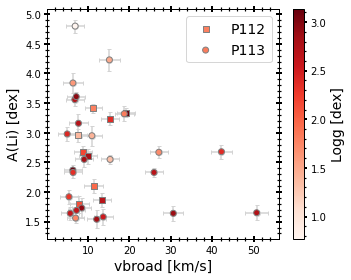

In [10]:
cmap = 'Reds'
vmin = np.min([np.min(p112_galah.logg), np.min(p113_galah.logg)])
vmax = np.max([np.max(p112_galah.logg), np.max(p113_galah.logg)])
plt.figure(figsize=(5,4))
plt.errorbar(p112_galah.vbroad, p112_galah.Li_val, xerr=p112_galah.e_vbroad, yerr=p112_galah.e_Li_val,fmt='o',c='lightgrey',capsize=2,mfc=None, mec=None,zorder=-100)
plt.errorbar(p113_galah.vbroad, p113_galah.Li_val, xerr=p113_galah.e_vbroad, yerr=p113_galah.e_Li_val,fmt='o',c='lightgrey',capsize=2,mfc=None, mec=None,zorder=-100)
plt.scatter(p112_galah.vbroad, p112_galah.Li_val, marker='s', c=p112_galah.logg, vmin=vmin, vmax=vmax, label='P112', cmap=cmap, ec='grey')
plt.scatter(p113_galah.vbroad, p113_galah.Li_val, marker='o', c=p113_galah.logg, vmin=vmin, vmax=vmax, label='P113', cmap=cmap, ec='grey')
plt.xlabel('vbroad [km/s]')
plt.ylabel('A(Li) [dex]')
plt.colorbar(label='Logg [dex]')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/ali_vbr.png',bbox_inches='tight',dpi=200)



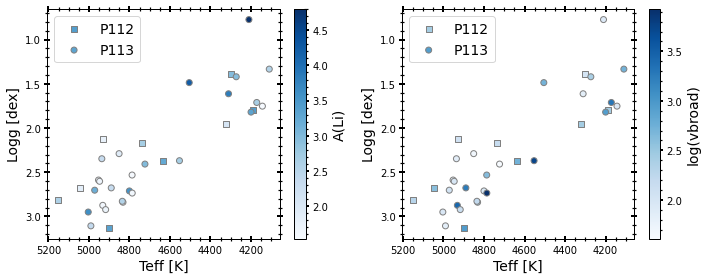

In [11]:
vmin = np.min([np.min(p112_galah.Li_val), np.min(p113_galah.Li_val)])
vmax = np.max([np.max(p112_galah.Li_val), np.max(p113_galah.Li_val)])
cmap = 'Blues'
plt.figure(figsize=(10,4))

ax1=plt.subplot(121)
plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=p112_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=p113_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='A(Li)')

ax2=plt.subplot(122,sharex=ax1, sharey=ax1)
vmin = np.log(np.min([np.min(p112_galah.vbroad), np.min(p113_galah.vbroad)]))
vmax = np.log(np.max([np.max(p112_galah.vbroad), np.max(p113_galah.vbroad)]))

plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=np.log(p112_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=np.log(p113_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='log(vbroad)')
plt.tight_layout()
#plt.savefig('../plots/sample_hrd.png',bbox_inches='tight',dpi=150)


In [12]:
# galah_ids_p112 = {
#     1: 150107004201104,
#     2: 151230003202196,
#     4: 161013005401317,
#     5: 161104004801189,
#     6: 150829004301285,
#     7: 160129003601260,
#     13: 190212001601338,
#     14: 140311007101261,
#     23: 170514002101318,
#     24: 171208003602294
# }

In [13]:
P112_snr = []
P113_snr = []

for k, v in obj_dir_p112.items():
    P112_snr.append(v['snr'])

for k, v in obj_dir_p113.items():
    P113_snr.append(v['snr'])
    
P112_snr = list(itertools.chain(*P112_snr))
P113_snr = list(itertools.chain(*P113_snr))

P112
27, 8-101, N=42
P113
24, 5-125, N=129


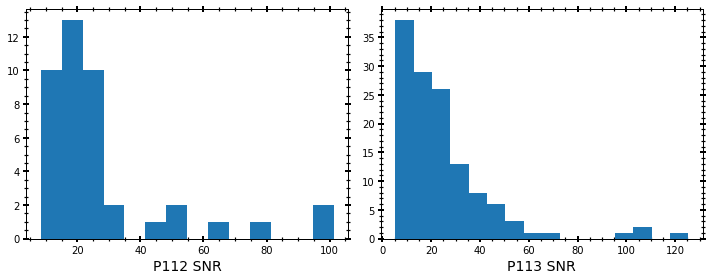

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(P112_snr,bins='auto')
plt.xlabel('P112 SNR')
plt.subplot(122)
plt.hist(P113_snr,bins='auto')
plt.xlabel('P113 SNR')
plt.tight_layout()


print('P112')
print('%i, %i-%i, N=%i'%(np.mean(P112_snr), np.min(P112_snr), np.max(P112_snr), len(P112_snr)))

print('P113')
print('%i, %i-%i, N=%i'%(np.mean(P113_snr), np.min(P113_snr), np.max(P113_snr), len(P113_snr)))

In [15]:
P112_err = []
P113_err = []

for k, v in obj_dir_p112.items():
    P112_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))

print('\n')
for k, v in obj_dir_p113.items():
    P113_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))
P112_err = list(itertools.chain(*P112_err))
P113_err = list(itertools.chain(*P113_err))

P112
0.022, 0.001-0.066, N=42
P113
0.040, 0.002-0.112, N=129


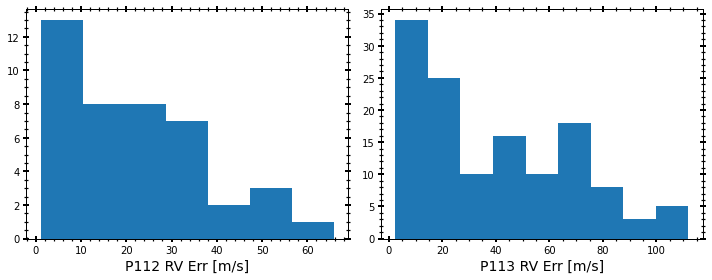

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist((P112_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P112 RV Err [m/s]')
plt.subplot(122)
plt.hist((P113_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P113 RV Err [m/s]')
plt.tight_layout()


print('P112')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P112_err), np.min(P112_err), np.max(P112_err), len(P112_err)))

print('P113')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P113_err), np.min(P113_err), np.max(P113_err), len(P113_err)))

In [17]:

obj_dir_p112_new = obj_dir_p112.copy()
obj_dir_p113_new = obj_dir_p113.copy()
obj_dir_p112_new = {'P112-%i' % k:v for k,v in obj_dir_p112_new.items()}
obj_dir_p113_new = {'P113-%i' % k:v for k,v in obj_dir_p113_new.items()}
obj_dir_both = obj_dir_p112_new.copy()
obj_dir_both.update(obj_dir_p113_new)
# myKeys = list(obj_dir_both.keys())
# myKeys.sort()
# obj_dir_both = {i: obj_dir_both[i] for i in myKeys}

print(len(obj_dir_both.keys()))

35


In [18]:
def make_rv_plot(obj_dir):
    #PLOT_PARAMS(LS=12)

    stats = {'RG_id':[], 'A': []}
    fig = plt.figure(figsize=(12,12))
    c=0
    obj_done = []
    for i, (obj, dat) in enumerate(obj_dir.items()):
        if obj.split('-')[0] == 'P112' and int(obj.split('-')[-1]) in in_112:
            continue
        elif obj.split('-')[0] == 'P113' and int(obj.split('-')[-1]) in in_113:
            continue
        else:
            c+=1
        if len(dat['time']) > 1 and c < 15:
            obj_done.append(obj)
            #obj = int(obj.split('-')[-1])
            #print(obj,obj_dir[obj])
            ax=plt.subplot(7,2,c)
            time    = np.array(obj_dir[obj]['time'])
            rv_vals = np.array(obj_dir[obj]['rv'])
            yerr    = np.array(obj_dir[obj]['err'])
            if obj != 'P113-5':
                mask = (rv_vals >= -100)
                time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
            #print(obj)
            t0   = time[0]
            rv0  = rv_vals[0]
            K0   = (max(rv_vals)-min(rv_vals))/2.

            plt.errorbar(time, rv_vals, 
                         yerr=yerr,
                         fmt='o', color='grey', mec='k', mfc='None', capsize=2)
            #plt.axhline(0, color='k',lw=1,ls='dotted')

            diff = abs(max(rv_vals)-min(rv_vals))
            '''if diff < 0.5:
                ax.set_facecolor('lightcoral')
            elif 0.5 <= diff < 0.7:
                ax.set_facecolor('bisque')
            elif 0.7 <= diff <= 50:
                ax.set_facecolor('lightgreen')
            '''
            #li = new_df[new_df.RG_id==obj]['Li_val'].values[0]
            #vb = new_df[new_df.RG_id==obj]['vbroad'].values[0]
            #li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].values()[0]
            #title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
            ax.text(0.03, 0.9, obj, transform=ax.transAxes,fontsize=14, ha='left',va='top')
            stats['RG_id'].append(obj)
            stats['A'].append(diff)
        #if i >= 13: 
        #    plt.xlabel(r'BJD Time [days]',fontsize=10)
        #if c % 2 == 0:
        #    plt.ylabel(r'Radial Velocity [km/s]')
        
    fig.text(0.5, 0.0, r'BJD Time [days]', ha='center',fontsize=14)
    fig.text(0.0, 0.5, r'Radial Velocity [km/s]', va='center', rotation='vertical',fontsize=14)
        
    plt.tight_layout()
    #plt.savefig('../plots/all_rv_1_%s.png'%DATE, bbox_inches='tight', dpi=200)
    plt.show()

    c=0
    fig = plt.figure(figsize=(12,12))
    
    for i, (obj, dat) in enumerate(obj_dir.items()):
        if obj in obj_done: 
            continue
        if obj.split('-')[0] == 'P112' and int(obj.split('-')[-1]) in in_112:
            continue
        elif obj.split('-')[0] == 'P113' and int(obj.split('-')[-1]) in in_113:
            continue
        else:
            c+=1
#         print(c)
        if len(dat['time']) > 1:
            #obj = int(obj.split('-')[-1])
            #print(obj,obj_dir[obj])
            ax=plt.subplot(6,2,c)
            time    = np.array(obj_dir[obj]['time'])
            rv_vals = np.array(obj_dir[obj]['rv'])
            yerr    = np.array(obj_dir[obj]['err'])
            if obj != 'P113-5':
                mask = (rv_vals >= -100)
                time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
            #print(obj)
            t0   = time[0]
            rv0  = rv_vals[0]
            K0   = (max(rv_vals)-min(rv_vals))/2.

            plt.errorbar(time, rv_vals, 
                         yerr=yerr,
                         fmt='o', color='grey', mec='k', mfc='None', capsize=2)
            #plt.axhline(0, color='k',lw=1,ls='dotted')

            diff = abs(max(rv_vals)-min(rv_vals))
            '''if diff < 0.5:
                ax.set_facecolor('lightcoral')
            elif 0.5 <= diff < 0.7:
                ax.set_facecolor('bisque')
            elif 0.7 <= diff <= 50:
                ax.set_facecolor('lightgreen')
            '''
            #li = new_df[new_df.RG_id==obj]['Li_val'].values[0]
            #vb = new_df[new_df.RG_id==obj]['vbroad'].values[0]
            #li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].values()[0]
            #title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
            ax.text(0.03, 0.9, obj, transform=ax.transAxes,fontsize=14, ha='left',va='top')
            stats['RG_id'].append(obj)
            stats['A'].append(diff)
    fig.text(0.5, 0.0, r'BJD Time [days]', ha='center',fontsize=14)
    fig.text(0.0, 0.5, r'Radial Velocity [km/s]', va='center', rotation='vertical',fontsize=14)
    plt.tight_layout()
    #plt.savefig('../plots/all_rv_2_%s.png'%DATE, bbox_inches='tight', dpi=200)

    plt.show()
    
#make_rv_plot(obj_dir_both)

In [19]:
in_113 = 7, 9, 11, 16, 18, 19, 21, 23  
in_112 = 6, 7, 13, 23

# targets above expectation: 7
targets above exp not confirmed as binary:
# targets above expectation: 4
targets above exp not confirmed as binary:


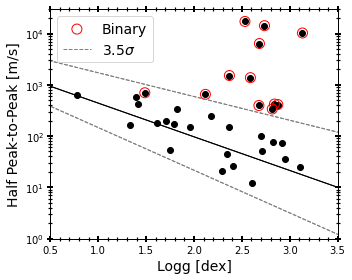

In [20]:
def half_rv(df, obj_dir, program):
    new_df = {'name':[], 'max_rv':[]}
    for k, v in obj_dir.items():
        new_df['name'].append(v['name'][0])
        rv_vals = np.array(v['rv'])
        if k!= 5:
            rv_vals = rv_vals[(rv_vals >= -100)]
        peak_to_peak = max(rv_vals) - min(rv_vals)
        new_df['max_rv'].append((peak_to_peak/2.)*1000)
    new_df = pd.DataFrame(new_df)
    
    merged = pd.merge(new_df, df, left_on='name',right_on='obj_name')
    if program==112:
        mbinary = merged[merged.RG_id.isin(in_112)]
    elif program==113:
        mbinary = merged[merged.RG_id.isin(in_113)]

    plt.scatter(merged.logg, merged.max_rv, c='k')
    plt.scatter(mbinary.logg, mbinary.max_rv, s=100, ec='red',fc='None', label='Binary')
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y
    
    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)
    #plt.axhline(10, c='grey',ls='dotted', lw=1)
    #plt.axvline(1.3, c='grey',ls='dotted', lw=1)
    plt.yscale('log')
    plt.xlabel('Logg [dex]')
    plt.ylabel('Half Peak-to-Peak [m/s]')
    plt.xlim(0.5,3.5)
    plt.ylim(1,3e4)
    if program == 113:
        plt.legend()
    n = merged[(merged.max_rv>300.) & (merged.logg>2)]
    n = n[~n.RG_id.isin(mbinary.RG_id)]
    #plt.scatter(n.logg, n.max_rv, c='grey')
    plt.tight_layout()
    # check how many targets fall above the 3.5 sigma line:
    exp = semi_log(5000, 4.0, 70, merged.logg).to_numpy()
    obs = merged.max_rv.to_numpy()
    N   = len(obs[obs > exp])
    print('# targets above expectation:',N)       
    print('targets above exp not confirmed as binary:')
    if len(n)>0:
        print('\t',n.RG_id.to_list())
        print('\t',n.vbroad.to_list())
        print('\t',n.Li_val.to_list())
    return merged
PLOT_PARAMS()
plt.figure(figsize=(5,4))
merged_113 = half_rv(p113_galah,obj_dir_p113,113)
merged_112 = half_rv(p112_galah,obj_dir_p112,112)
#plt.savefig('../plots/peak_to_peak_%s.png'%DATE,bbox_inches='tight',dpi=200)

# targets above expectation: 7
targets above exp not confirmed as binary:
	 []
# targets above expectation: 4
targets above exp not confirmed as binary:
	 []


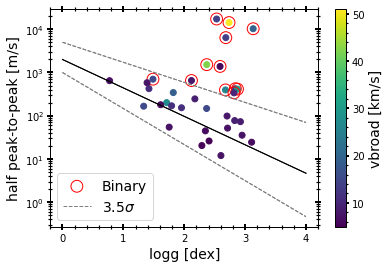

In [21]:
def half_rv(df, obj_dir, program):
    new_df = {'name':[], 'max_rv':[]}
    for k, v in obj_dir.items():
        new_df['name'].append(v['name'][0])
        rv_vals = np.array(v['rv'])
        if k!= 5:
            rv_vals = rv_vals[(rv_vals >= -100)]
        peak_to_peak = max(rv_vals) - min(rv_vals)
        new_df['max_rv'].append((peak_to_peak/2.)*1000)
    new_df = pd.DataFrame(new_df)
    
    merged = pd.merge(new_df, df, left_on='name',right_on='obj_name')
    if program==112:
        mbinary = merged[merged.RG_id.isin(in_112)]
    elif program==113:
        mbinary = merged[merged.RG_id.isin(in_113)]
    vmin, vmax = 5, 51

    plt.scatter(merged.logg, merged.max_rv, c=merged.vbroad, vmin=vmin, vmax=vmax)
    if program==113:
        plt.colorbar(label='vbroad [km/s]')
    plt.scatter(mbinary.logg, mbinary.max_rv, s=140, ec='red',fc='None', label='Binary')
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y
    
    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)
    #plt.axhline(10, c='grey',ls='dotted', lw=1)
    #plt.axvline(1.3, c='grey',ls='dotted', lw=1)
    plt.yscale('log')
    plt.xlabel('logg [dex]')
    plt.ylabel('half peak-to-peak [m/s]')
    if program == 113:
        plt.legend()
    n = merged[(merged.max_rv>300.) & (merged.logg>2)]
    n = n[~n.RG_id.isin(mbinary.RG_id)]
    #plt.scatter(n.logg, n.max_rv, c='grey')
    
    # check how many targets fall above the 3.5 sigma line:
    exp = semi_log(5000, 4.0, 70, merged.logg).to_numpy()
    obs = merged.max_rv.to_numpy()
    N   = len(obs[obs > exp])
    print('# targets above expectation:',N)       
    print('targets above exp not confirmed as binary:')
    print('\t',n.RG_id.to_list())
#     if program==113:
#         n = merged[merged.RG_id == 19]
#         plt.scatter(n.logg, n.max_rv, color='r')
plt.figure()
half_rv(p113_galah,obj_dir_p113,113)
half_rv(p112_galah,obj_dir_p112,112)


1.0794814988486947 4.236917426774277


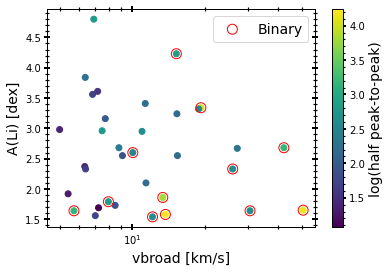

In [22]:
plt.figure()
vmin = min([min(np.log10(merged_112.max_rv)), min(np.log10(merged_113.max_rv))])
vmax = max([max(np.log10(merged_112.max_rv)), max(np.log10(merged_113.max_rv))])
print(vmin, vmax)
plt.scatter(merged_112.vbroad, merged_112.Li_val, c=np.log10(merged_112.max_rv), vmin=vmin ,vmax=vmax)
plt.scatter(merged_113.vbroad, merged_113.Li_val, c=np.log10(merged_113.max_rv), vmin=vmin ,vmax=vmax)
plt.colorbar(label='log(half peak-to-peak)')
mbinary = merged_112[merged_112.RG_id.isin(in_112)]

plt.scatter(mbinary.vbroad, mbinary.Li_val, ec='r', s=100, fc='None')
mbinary = merged_113[merged_113.RG_id.isin(in_113)]
plt.scatter(mbinary.vbroad, mbinary.Li_val, ec='r', s=100, fc='None', label='Binary')
plt.legend()
plt.xlabel('vbroad [km/s]')
plt.ylabel('A(Li) [dex]')
plt.xscale('log')

In [23]:
p113_galah[p113_galah.RG_id==21].sobject_id

20    160327006601149
Name: sobject_id, dtype: int64

In [24]:
def period_at_surface(M1, logg, e, M2=0*u.Msun):
    import astropy.units as u
    from astropy.constants import G

    R1 = np.sqrt(G*M1 / (10**logg * u.cm/u.s**2))
    q = M2 / M1
    P = 2*np.pi * (G*(M1+M2) / R1**3)**(-1/2) * (1-e)**(-3/2) * (1+q)**1.5
    return P.to(u.day)

period_at_surface(M1 = 2.4*u.Msun, logg=2.67, e=0.3)

<Quantity 5.21554606 d>

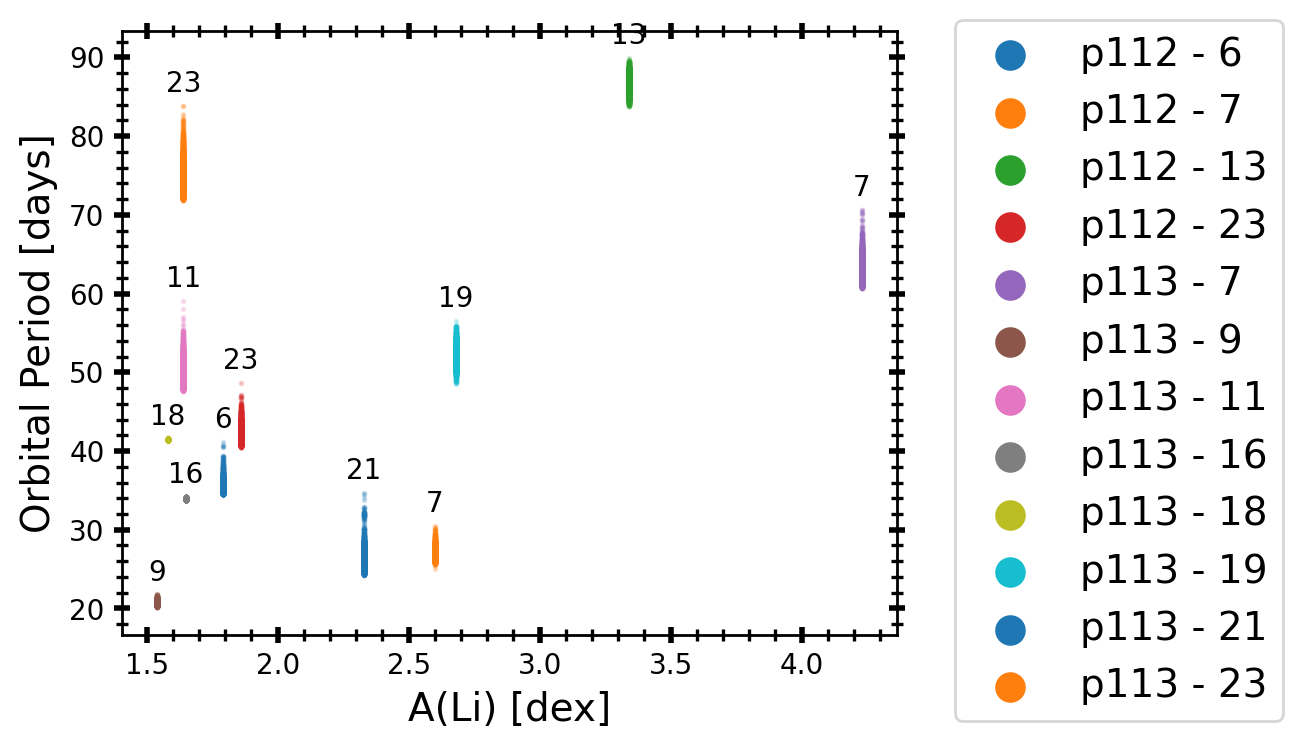

In [25]:
def make_density_plot_P():
    PLOT_PARAMS()
    program = 'p112'
    version = 1
    fig = plt.figure(figsize=(5,4),dpi=200)
    ax  = plt.subplot(111)
    for RG in in_112:
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']
        
        Li_val = merged_112[merged_112.RG_id==RG]['Li_val'].values[0]
        P_vals  = mcmc_samples.tbl.to_pandas()['P']
        Li_vals = [Li_val]*len(P_vals) 
        plt.scatter(Li_vals,P_vals ,s=1,alpha=0.2,label='%s - %s'%(program, RG))
        plt.text(Li_val, max(P_vals)+1, s=RG, ha='center',va='bottom')
        
    program = 'p113'
    for RG in in_113:
        if (RG==16 or RG==11):
            version = 2
        else:
            version = 1
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        colnames = ['P','e','K','v0']
        
        Li_val = merged_113[merged_113.RG_id==RG]['Li_val'].values[0]
        P_vals  = mcmc_samples.tbl.to_pandas()['P']
        Li_vals = [Li_val]*len(P_vals) 
        plt.scatter(Li_vals,P_vals ,s=1,alpha=0.2,label='%s - %s'%(program, RG))
        plt.text(Li_val, max(P_vals)+1, s=RG, ha='center',va='bottom')
        
    lgnd = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1.05))
    for lh in lgnd.legend_handles: 
        lh.set_alpha(1)
    plt.xlabel('A(Li) [dex]')
    plt.ylabel('Orbital Period [days]')
    
make_density_plot_P()

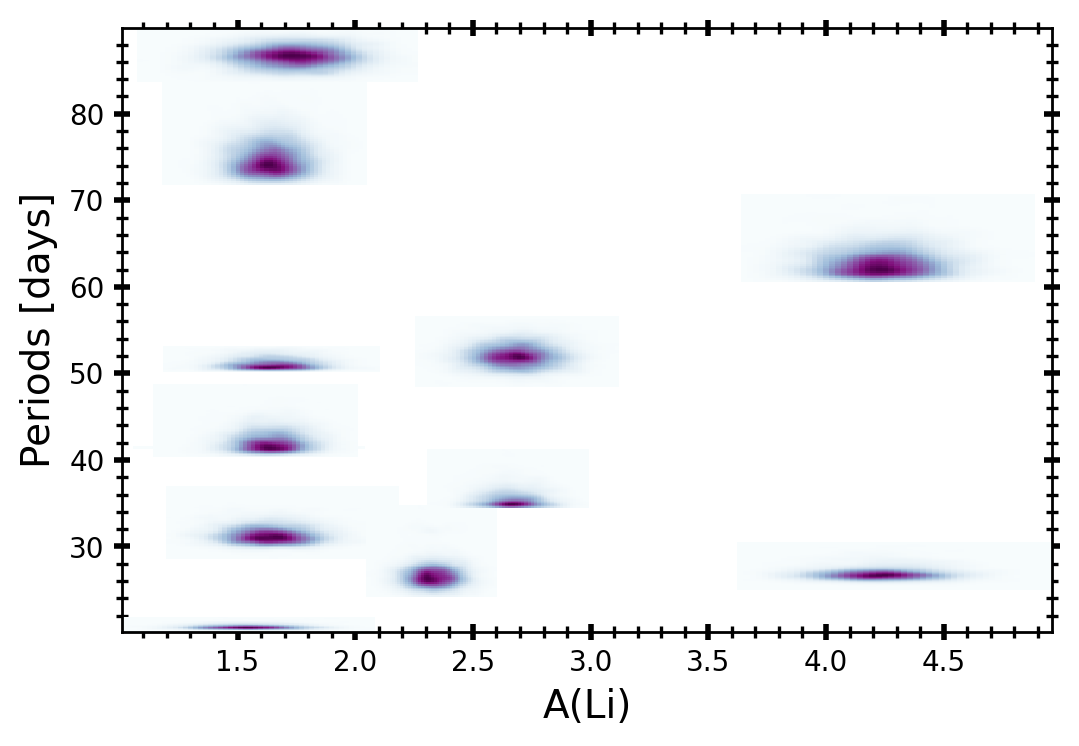

In [95]:
def make_2d_kde(version=1):
    from scipy.stats import gaussian_kde
    plt.figure(dpi=200)
    program='p113'
    for RG in in_113:
        fname = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        mcmc = np.array(mcmc_samples['P'])
        A_Li = merged_113[merged_113.RG_id==RG]['Li_val'].values[0]
        e_Li = merged_113[merged_113.RG_id==RG]['e_Li_val'].values[0]

        mu, sigma = A_Li, e_Li
        Li_val = np.random.normal(mu, sigma, len(mcmc))
        data = np.array([Li_val, mcmc]).T
        x, y = Li_val*1, mcmc*1
        nbins = 50
        k = gaussian_kde(data.T)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax = plt.subplot(111)
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.BuPu)
    program='p112'
    for RG in in_112:

        fname = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        mcmc = np.array(mcmc_samples['P'])
        A_Li = merged_113[merged_113.RG_id==RG]['Li_val'].values[0]
        e_Li = merged_113[merged_113.RG_id==RG]['e_Li_val'].values[0]

        mu, sigma = A_Li, e_Li
        Li_val = np.random.normal(mu, sigma, len(mcmc))
        data = np.array([Li_val, mcmc]).T
        x, y = Li_val*1, mcmc*1
        nbins = 50
        k = gaussian_kde(data.T)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax = plt.subplot(111)
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.BuPu)
    plt.xlabel('A(Li)')
    plt.ylabel('Periods [days]')
#     return merged_113
make_2d_kde()   

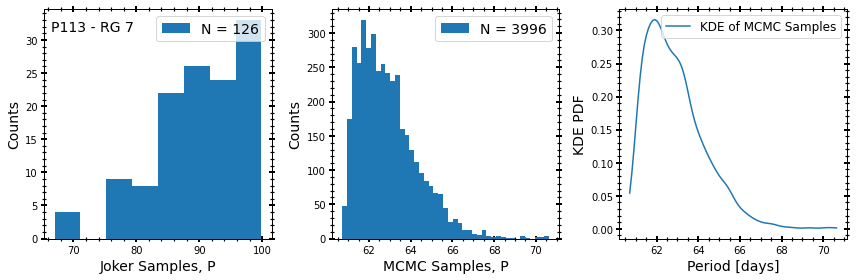

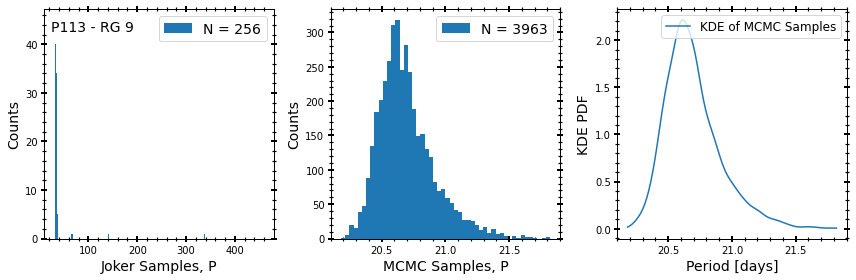

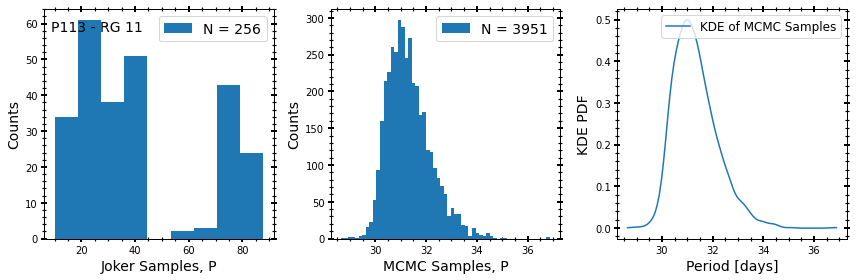

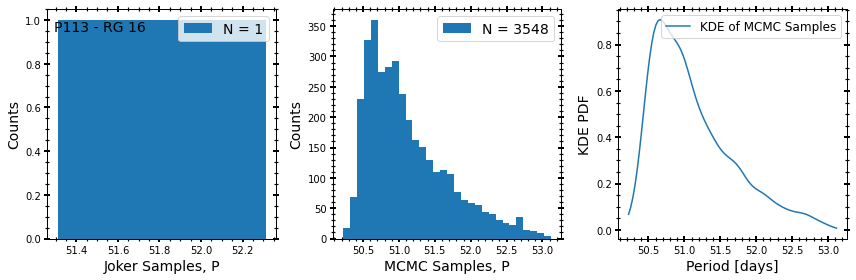

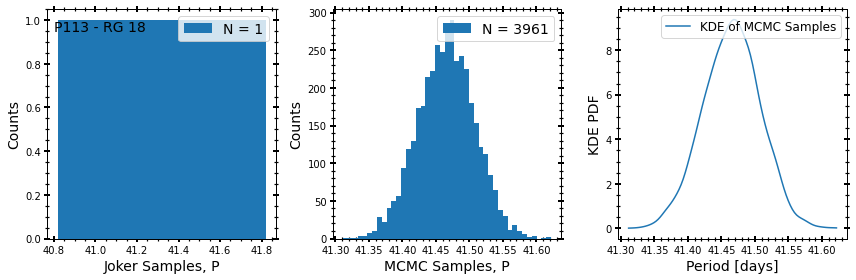

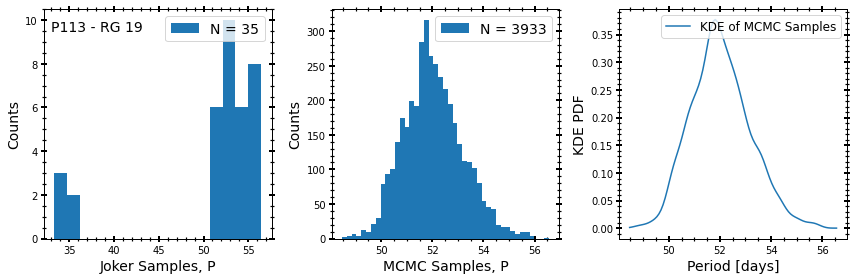

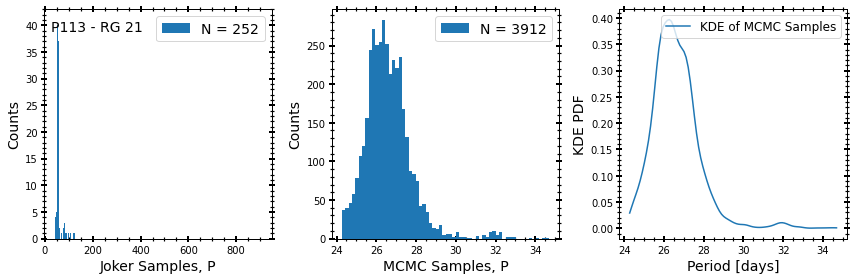

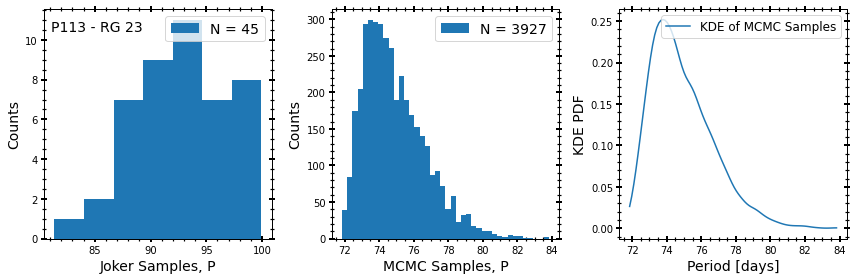

In [70]:
def make_density_plot_P():
    from scipy.stats import gaussian_kde
    program = 'p112'
    version = 1
    for RG in in_112:
        fname = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,RG,version)
        joker_samples = tj.JokerSamples.read(fname)
        x = np.array(joker_samples['P'])
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.hist(x,bins='auto',label='N = %i' % (len(x)))
        plt.xlabel('Joker Samples, P')
        plt.ylabel('Counts')
        plt.legend()
        
        plt.subplot(132)
        mcmc = np.array(mcmc_samples['P'])
        plt.hist(mcmc,bins='auto',label='N = %i' % (len(mcmc)))
        plt.xlabel('MCMC Samples, P')
        plt.ylabel('Counts')
        plt.legend()

        # Create a KDE object
        kde = gaussian_kde(mcmc)

        # Evaluate the KDE at a range of points
        x = np.linspace(min(mcmc), max(mcmc), 100)
        y = kde(x)
        plt.subplot(133)
        # Plot the KDE
        plt.plot(x, y, label='KDE of MCMC Samples')
        plt.xlabel('Period [days]')
        plt.ylabel('KDE PDF')
        plt.legend(loc='upper right',fontsize=12)
        plt.tight_layout()
        plt.show()
        
    program = 'p113'
    version = 1
    for RG in in_113:
        fname = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,RG,version)
        joker_samples = tj.JokerSamples.read(fname)
        x = np.array(joker_samples['P'])
        plt.figure(figsize=(12,4))
        ax = plt.subplot(131)
        plt.hist(x,bins='auto',label='N = %i' % (len(x)))
        plt.xlabel('Joker Samples, P')
        plt.ylabel('Counts')
        plt.legend(loc='upper right')
        plt.text(0.03, 0.95, s='P113 - RG %i'%RG, ha='left', va='top', transform=ax.transAxes, fontsize=14)
        
        plt.subplot(132)
        mcmc = np.array(mcmc_samples['P'])
        plt.hist(mcmc,bins='auto',label='N = %i' % (len(mcmc)))
        plt.xlabel('MCMC Samples, P')
        plt.ylabel('Counts')
        plt.legend()

        # Create a KDE object
        kde = gaussian_kde(mcmc)

        # Evaluate the KDE at a range of points
        x = np.linspace(min(mcmc), max(mcmc), 100)
        y = kde(x)
        plt.subplot(133)
        # Plot the KDE
        plt.plot(x, y, label='KDE of MCMC Samples')
        plt.xlabel('Period [days]')
        plt.ylabel('KDE PDF')
        plt.legend(loc='upper right',fontsize=12)
        plt.tight_layout()
        plt.show()

make_density_plot_P()

In [26]:
ss

NameError: name 'ss' is not defined

In [ ]:
def make_density_plot_e():
    PLOT_PARAMS()
    program = 'p112'
    version = 1
    fig = plt.figure()
    ax  = plt.subplot(111)
    for RG in in_112:
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        fname2 = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        with open(fname2, 'rb') as handle:
            trace = pickle.load(handle)
        colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        
        Li_val = merged_112[merged_112.RG_id==RG]['Li_val'].values[0]
        e_vals  = mcmc_samples.tbl.to_pandas()['e']
        Li_vals = [Li_val]*len(e_vals) 
        plt.scatter(Li_vals,e_vals ,s=1,alpha=0.2,label='%s - %s'%(program, RG))
        
    program = 'p113'
    for RG in in_113:
        if (RG==16 or RG==11):
            version = 2
        else:
            version = 1
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        fname2 = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        with open(fname2, 'rb') as handle:
            trace = pickle.load(handle)
        colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        
        Li_val = merged_113[merged_113.RG_id==RG]['Li_val'].values[0]
        e_vals  = mcmc_samples.tbl.to_pandas()['e']
        Li_vals = [Li_val]*len(e_vals) 
        plt.scatter(Li_vals,e_vals ,s=1,alpha=0.2,label='%s - %s'%(program, RG))
    lgnd = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1.05))
    for lh in lgnd.legend_handles: 
        lh.set_alpha(1)
    plt.xlabel('A(Li) [dex]')
    plt.ylabel('Eccentricity')
make_density_plot_e()

# Make corner plot - P112

In [ ]:
def make_corner_plots(save=False, show=False):
    program = 'p112'
    version = 1
    for RG in in_112:
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        fname2 = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        with open(fname2, 'rb') as handle:
            trace = pickle.load(handle)
        colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        rhat = summary['r_hat'].to_list() 
        print(RG, rhat)
        fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                            labels=[
                                r"$P$", r"$e$", r"$K$",r"$v_0$"],
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                           )
        if save: plt.savefig('../plots/corner/112_%s_%s.png'%(RG, DATE),bbox_inches='tight',dpi=200)
        if show: plt.show(False)
        print('\n')
#make_corner_plots()

# Make corner plot - P113

In [ ]:
def make_corner_plots(save=False, show=False):
    program = 'p113'
    version = 1
    for RG in in_113:
        fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
        fname2 = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname1, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        with open(fname2, 'rb') as handle:
            trace = pickle.load(handle)
        if RG == 16:
            colnames = ['P','e','K','v0','v1','v2']
            labels = [r"$P$", r"$e$", r"$K$",r"$v_0$",r"$v_1$",r"$v_2$"]
    #     elif RG == 23:
    #         colnames = ['P','e','K','M0','omega','v0']
    #         labels = [r"$P$", r"$e$", r"$K$",r"$M_0$",r"$\omega$",r"$v_0$"]
        else:
            colnames = ['P','e','K','v0']
            labels = [r"$P$", r"$e$", r"$K$",r"$v_0$"]

        summary = az.summary(trace, colnames)
        rhat = summary['r_hat'].to_list() 
        print(RG, rhat)
        fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                            labels=labels,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                           )
        if save: plt.savefig('../plots/corner/113_%s_%s.png'%(RG, DATE),bbox_inches='tight',dpi=200)

        if show: fig.show()
        print('\n')

    #     print(mcmc_samples)
    #     print(trace)
#make_corner_plots()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_stats(binaries, program, version, stat_dict):
    for i,RG in enumerate(binaries):
        fname = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,version)
        with open(fname, 'rb') as handle:
            trace = pickle.load(handle)
        if RG == 16:
            colnames = ['P','e','K','v0','v1','v2']
        else:
            colnames = ['P','e','K','v0']
        summary = az.summary(trace, colnames)
        #print(summary)
        #rhat = summary['r_hat'].to_list() 
#         print(RG, rhat)
        
        stat_dict[i] = [RG, summary['mean']['P'], summary['sd']['P'], summary['mean']['e'], summary['sd']['e'], 
                         summary['r_hat']['P'], summary['r_hat']['e'],
                        ]
    df = pd.DataFrame(stat_dict, )
    df = df.T
    df.columns = ['RG_id','P','err_P','e','err_e','r_hat_P','r_hat_e']
    if '112' in program:
        df1 = df_p112
    elif '113' in program:
        df1 = df_p113
    df = pd.merge(df, df1, on='RG_id')
    return df
stat_dict = {}
stat_dict_112 = get_stats(in_112, 'p112', 1, stat_dict)
stat_dict_113 = get_stats(in_113, 'p113', 1, stat_dict)
stats_df = pd.concat([stat_dict_112,stat_dict_113]).reset_index()
stats_df


In [ ]:
def plot_js(obj, obj_dir, ax, program='p112',version=1):
    if (obj==16 or obj==11) and program=='p113':
        version = 2
    else:
        version = 1
    fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    t, rv, rv_err = np.array(obj_dir[obj]['time']), np.array(obj_dir[obj]['rv']), np.array(obj_dir[obj]['err'])
    mask = (rv >= -100)
    t, rv, rv_err = t[mask], rv[mask], rv_err[mask]

    data = Table()
    data['bjd']     = t
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS()

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
fig=plt.figure(dpi=150)
ax=plt.subplot(111)
plot_js(21, obj_dir_p113, ax=ax, program='p113')

In [ ]:
def plot_joker_samples(obj, obj_dir, ax, program='p112',version=1):
    if (obj==16 or obj==11) and program=='p113':
        version = 2
    else:
        version = 1
    fname = '../mcmc/%s/%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    t, rv, rv_err = np.array(obj_dir[obj]['time']), np.array(obj_dir[obj]['rv']), np.array(obj_dir[obj]['err'])
    mask = (rv >= -100)
    t, rv, rv_err = t[mask], rv[mask], rv_err[mask]

    data = Table()
    data['bjd']     = t
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS()

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    if program=='p112':
        ax.text(0.5, 0.9, '112 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center')
    else:
        ax.text(0.5, 0.9, '113 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center',)
    
fig, axes = plt.subplots(4, 3, figsize=(15, 12),dpi=200)

for i, ax in enumerate(fig.axes):
    if i < len(in_112):
        obj = in_112[i]
        plot_joker_samples(obj, obj_dir_p112, ax=ax, program='p112')
    elif i >= len(in_112):
        obj = in_113[i-len(in_112)]
        plot_joker_samples(obj, obj_dir_p113, ax=ax, program='p113')
    
plt.tight_layout()
#plt.savefig('../plots/all_joker_samples_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:
# plt.figure(figsize=(8,6))
# plt.subplot(221)
# plt.scatter(both_galah.Li_val, both_galah.Ba_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Ba_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Ba/Fe')
# plt.legend(fontsize=12,loc='lower right')

# plt.subplot(222)
# plt.scatter(both_galah.Li_val, both_galah.La_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.La_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('La/Fe')
# plt.legend(fontsize=12,loc='upper right')

# plt.subplot(223)
# plt.scatter(both_galah.Li_val, both_galah.Y_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Y_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Y/Fe')
# plt.legend(fontsize=12,loc='upper right')

# plt.subplot(224)
# plt.scatter(both_galah.Li_val, both_galah.Zr_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Zr_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Zr/Fe')
# plt.legend(fontsize=12,loc='upper right')
# plt.tight_layout()

In [ ]:
# plt.figure(figsize=(8,6),dpi=150)
# plt.subplot(221)
# plt.scatter(both_galah.Li_val, both_galah.Ba_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Ba_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Ba/Fe')
# plt.legend(fontsize=12,loc='lower right')

# plt.subplot(222)
# plt.scatter(both_galah.Li_val, both_galah.La_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.La_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('La/Fe')
# plt.legend(fontsize=12,loc='upper right')

# plt.subplot(223)
# plt.scatter(both_galah.Li_val, both_galah.Y_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Y_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Y/Fe')
# plt.legend(fontsize=12,loc='upper right')

# plt.subplot(224)
# plt.scatter(both_galah.Li_val, both_galah.Zr_fe, c='k')
# plt.scatter(stats_df.Li_val, stats_df.Zr_fe, s=140, ec='red',fc='None', label='Binary')
# plt.xlabel('A(Li)')
# plt.ylabel('Zr/Fe')
# plt.legend(fontsize=12,loc='upper right')
# plt.tight_layout()

In [ ]:
plt.figure(figsize=(5,4),dpi=200)
bins=np.arange(1.5, 5, 0.5)
both_galah = pd.concat([p112_galah, p113_galah])
plt.hist(both_galah.Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
plt.hist(stats_df.Li_val.values, bins=bins, label='Binary',color='firebrick', ec='k')
plt.xlabel('A(Li) [dex]')
plt.ylabel('Counts')
plt.legend()

In [ ]:
stats_df.keys()

In [ ]:
def find_trends(df):
    plt.figure(figsize=(5,4),dpi=200)
    plt.subplot(111)
    plt.errorbar(df.Li_val, df.P,fmt='o',color='k',capsize=2,lw=1,xerr=df.e_Li_val, yerr=df.err_P, 
                 mfc='firebrick',mec='firebrick')
    plt.xlabel('A(Li) [dex]')
    plt.ylabel('Period [days]')
    
    plt.figure(figsize=(5,4),dpi=200)
    plt.subplot(111)
    plt.errorbar(df.Li_val, df.e,fmt='o',color='k',capsize=2,lw=1,xerr=df.e_Li_val, yerr=df.err_e, mfc='firebrick',mec='firebrick')
    plt.xlabel('A(Li) [dex]')
    plt.ylabel('Eccentricity')
    
    plt.figure(figsize=(5,4),dpi=200)
    plt.subplot(111)
    plt.errorbar(df.vbroad, df.P,fmt='o',color='k',capsize=2,lw=1,xerr=df.e_vbroad, yerr=df.err_P, mfc='firebrick',mec='firebrick')
    plt.xlabel('vbroad [km/s]')
    plt.ylabel('Period [days]')
        
    plt.figure(figsize=(5,4),dpi=200)
    plt.subplot(111)
    plt.errorbar(df.vbroad, df.e,fmt='o',color='k',capsize=2,lw=1,xerr=df.e_vbroad, yerr=df.err_e, mfc='firebrick',mec='firebrick')
    plt.xlabel('vbroad [km/s]')
    plt.ylabel('Eccentricity')
    plt.tight_layout()
    
find_trends(stats_df)

In [ ]:
def test_phase_fold(obj, obj_dir, program='p112',version=1):
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,obj,version)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)

    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print(obj_dir[obj]['time'])
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))

    i=5
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(mcmc_samples.mean(), data=data, ax=ax)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    _=tj.plot_phase_fold(mcmc_samples.mean(), data=data, ax=ax)
        
# test_phase_fold(7, obj_dir_p112)

In [ ]:
def t(obj_dir):
    obj = 16
    fname = '../mcmc/%s/%s_joker_%s.hdf5'%('p113',16,2)
    joker_samples = tj.JokerSamples.read(fname)
    print(joker_samples)

    t, rv, rv_err = np.array(obj_dir[obj]['time']), np.array(obj_dir[obj]['rv']), np.array(obj_dir[obj]['err'])
    mask = (rv >= -100)
    t, rv, rv_err = t[mask], rv[mask], rv_err[mask]
    data = Table()
    data['bjd']     = t
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    ax=plt.subplot(111)
    _ = tj.plot_rv_curves(joker_samples,data=data,ax=ax)
t(obj_dir_p113)

In [ ]:
len(axes[1])
DATE

## Plot log-likelihood

In [ ]:
# P112
program = 'p112'
version = 1
plt.figure(figsize=(12,3))
for i,RG in enumerate(in_112):
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    ax=plt.subplot(1,4,i+1)
    _ = plt.hist(mcmc_samples['ln_likelihood'].value,bins='auto')
    ax.text(0.03, 0.9, '112 - RG %s'%RG, transform=ax.transAxes,fontsize=14)
    plt.xlabel(r'$\log(\mathcal{L})$')
    if i==0: plt.ylabel('Counts')

plt.tight_layout()
#plt.savefig('../plots/likelihood_1_%s.png'%DATE, bbox_inches='tight', dpi=200)

plt.show()

# P113
program = 'p113'
version = 1
plt.figure(figsize=(12,6))
for i,RG in enumerate(in_113):
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,version)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    ax=plt.subplot(2,4,i+1)
    _ = plt.hist(mcmc_samples['ln_likelihood'].value,bins='auto')
    ax.text(0.03, 0.9, '113 - RG %s'%RG, transform=ax.transAxes,fontsize=14)
    plt.xlabel(r'$\log(\mathcal{L})$')
    if i % 4 == 0: plt.ylabel('Counts')

plt.tight_layout()
#plt.savefig('../plots/likelihood_2_%s.png'%DATE, bbox_inches='tight', dpi=200)
plt.show()